## SVD-based ICP

In [199]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import imageio, glob
from matplotlib import animation, rc
from IPython.display import Image, display
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

In [200]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    

def gen_video(filenames, video_name, fps=1):
    with imageio.get_writer(video_name, fps=fps, loop=0) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

In [201]:

# initialize pertrubation rotation
def generate_2D_points(vis=False):
    # initialize pertrubation rotation
    angle = pi / 4
    R_true = np.array([[cos(angle), -sin(angle)], 
                    [sin(angle),  cos(angle)]])
    t_true = np.array([[-2], [5]])

    # Generate data as a list of 2d points
    num_points = 30
    true_data = np.zeros((2, num_points))
    true_data[0, :] = range(0, num_points)
    true_data[1, :] = 0.2 * true_data[0, :] * np.sin(0.5 * true_data[0, :]) 
    # Move the data
    moved_data = R_true.dot(true_data) + t_true

    # Assign to variables we use in formulas.
    Q = true_data
    P = moved_data
    
    if vis:
        plot_data(moved_data, true_data, "P: moved data", "Q: true data")
        plt.show()
    return Q, P

Q, P = generate_2D_points()

In [202]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q.
        P: (2, N) the array of points
        Q: (2, N) the array of points
    """
    P_size = P.shape[1]
    Q_size = Q.shape[1]
    correspondence = list()
    for i in range(P_size):
        p_i = P[:, i].reshape(2, 1)
        dist = np.linalg.norm(p_i - Q, axis=0) # (1, N)
        nearest_index = np.argmin(dist)
        correspondence.append((i, nearest_index))
    return correspondence

def draw_correspondeces(P, Q, correspondences, ax, title=''):
    label_added = False
    if not isinstance(correspondences, np.ndarray):
        correspondences = np.array(correspondences)
    if correspondences.shape[0] == 2 or correspondences.shape[0] == 3:
        correspondences = correspondences.T
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.set_title(title)
    ax.legend()

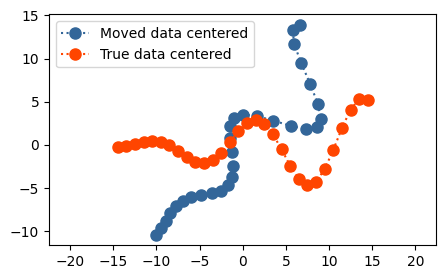

In [203]:
def center_data(data):
    center_of_data = np.mean(data, axis=-1, keepdims=True)
    data_centered = data - center_of_data
    return center_of_data, data_centered
center_of_P, P_centered = center_data(P)
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

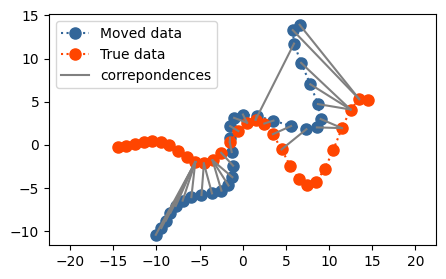

In [204]:
correspondence = get_correspondence_indices(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered, "Moved data", "True data")
draw_correspondeces(P_centered, Q_centered, correspondence, ax)
plt.show()

In [205]:
def visualize(P, Q, correspondence, error, i, vis=False, folder_name='svd_based_icp'):
    ax = plot_data(P, Q, "Moved data", "True data")
    draw_correspondeces(P, Q, correspondence, ax, f'Iteration: {i}, Error: {error:.2f}')
    if vis:
        plt.show()
    else:
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        plt.savefig(f'{folder_name}/{i:02d}.png')
    plt.close()
    
def svd_based_icp(P, Q, P_center, Q_center):
    # calculate the H matrix
    H = np.dot(P, Q.T)
    
    # svd
    U, Omega, Vt = np.linalg.svd(H)
    
    # calculate R, t
    R = np.dot(Vt.T, U.T)
    t = Q_center - np.dot(R, P_center)
    
    T = np.eye(3, 3)
    T[:2, :2] = R
    T[:2, 2:] = t
    return T

def fit(P, Q):
    iteration = 30
    threshold = 1e-3
    P_values = list()
    corresp_values = list()
    Q_center, Q_centered = center_data(Q)
    for i in range(iteration):
        error = np.mean(np.linalg.norm(P - Q, axis=0))
        if error < threshold:
            break
        P_center, P_centered = center_data(P)
        correspondence = get_correspondence_indices(P_centered, Q_centered)
        
        correspondence = np.array(correspondence).T
     
        T = svd_based_icp(P_centered, Q_centered[:, correspondence[1, :]], P_center, Q_center)
        P = T[:2,:2] @ P + T[:2, 2:]
        
        P_values.append(P) 
        corresp_values.append(correspondence)
        visualize(P, Q, correspondence, error, i, vis=False)
        
    correspondence = get_correspondence_indices(P_centered, Q_centered)
    correspondence = np.array(correspondence).T
    visualize(P, Q, correspondence, error, i, vis=False)
    return P_values, corresp_values
    

In [206]:
P_values, corresp_values = fit(P_centered, Q_centered)

In [207]:
gen_video(glob.glob('svd_based_icp/*.png'), 'svd_based_icp.gif')


C:\Users\Cristina Wu\AppData\Local\Temp\ipykernel_22392\1212044731.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


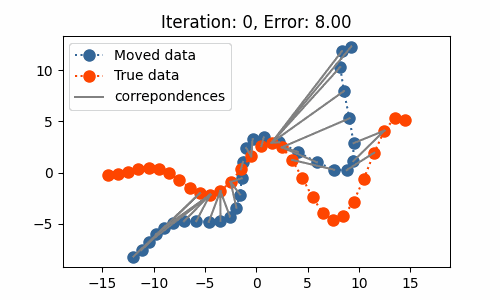

In [208]:
display(Image(filename='svd_based_icp.gif'))

## Non-Linear Least Squared ICP

In [209]:
def Jacobian(theta, x, y):
    J = np.zeros((2, 3))
    J[:2, :2] = np.identity(2)
    J[:2, [2]] = dR(theta) @ np.array([[x], [y]])
    return J

def R(theta):
    return np.array([[cos(theta), -sin(theta)],
                     [sin(theta),  cos(theta)]])
    
def dR(theta):
    return np.array([[-sin(theta), -cos(theta)],
                     [cos(theta),  -sin(theta)]])
def non_linear_least_squared_icp(P, Q):
    max_iter = 30
    theta = 0
    threshold = 1e-3
    x = np.zeros((3, 1))
    P_values = list()
    correspondences = list()
    Ts = list()
    P_copy = P.copy()
    for iter in range(max_iter):
    
        correspondence = get_correspondence_indices(P_copy, Q) # NOTICE: Use updated P to calculate correspondences
        correspondence = np.array(correspondence)
        H = np.zeros((3, 3))
        bn = np.zeros((3, 1))
        for i, j in correspondence:
            p = P[:, i].reshape(2, 1) # NOTICE: Use original P to calculate the error `en` and Jacobian Matrix `Jm`
            q = Q[:, j].reshape(2, 1)
            rot = R(x[2])
            t = x[:2].reshape(2, 1)
            en = rot @ p + t - q
            Jm = Jacobian(x[2], p[0].item(), p[1].item())
          
            H += Jm.T @ Jm
            bn += Jm.T @ en
            
        dx = np.linalg.lstsq(H, -bn, rcond=None)[0]
        x += dx
        x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle!
        rotation = R(x[2])
        translation = x[:2]
   
        P_copy = rotation @ P.copy() + translation # NOTICE: update the P_copy
        error = np.mean(np.linalg.norm(P_copy - Q, axis=0))
        P_values.append(P_copy)
        correspondences.append(correspondence)
        
        visualize(P_copy, Q, correspondence, error, iter, vis=False, folder_name='non_linear_least_squared_icp')
        if error < threshold:
            break
    
    return P_values, correspondences, Ts
Q, P = generate_2D_points()
P_values, correspondences, Ts = non_linear_least_squared_icp(P, Q)

C:\Users\Cristina Wu\AppData\Local\Temp\ipykernel_22392\1212044731.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


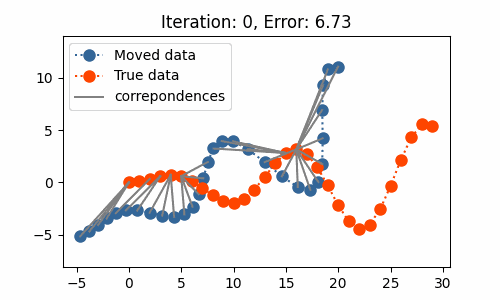

In [210]:
gen_video(sorted(glob.glob('non_linear_least_squared_icp/*.png')), 'non_linear_least_squared_icp.gif', fps=2)
display(Image(filename='non_linear_least_squared_icp.gif'))